In [12]:
%pip install --quiet cplex

Note: you may need to restart the kernel to use updated packages.


In [13]:
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import CplexOptimizer
import numpy as np
import matplotlib.pyplot as plt

In [14]:
num_bins = 24                                   # Number of time bins
e = np.array([50, 10, 50, 50, 10])              # Energy requests in kWh
num_evs = len(e)                                # Number of charging spaces or outlets
V = 240                                         # Voltage in volts
dt = 0.5                                        # Time step duration in hours
max_power = 20                                  # Maximum power in kW
arr_times = np.array([0, 3, 4, 6, 7])           # Arrival time bins
dep_times = np.array([10, 20, 23, 19, 21])      # Departure time bins

In [15]:
# Initialize the model
mdl = Model(name='EV Charging Schedule')

# Decision variable: charging current for each EV at each time step
r = mdl.integer_var_matrix(num_evs, num_bins, lb=0, ub=64, name='r')

# Compute delivered energy for each EV in kWh
delivered_energy = [mdl.sum(r[i, t] for t in range(num_bins)) * V * dt / 1000 for i in range(num_evs)]

# Compute energy deviation for each EV
energy_deviation = [delivered_energy[i] - e[i] for i in range(num_evs)]

# Fast charging incentive: penalize later charging times
time_penalty = np.zeros((num_evs, num_bins))
for i in range(num_evs):
    time_penalty[i, arr_times[i]:dep_times[i]] = np.arange(arr_times[i], dep_times[i])

# First Objective function
fast_charging = mdl.sum(r[i, t] * time_penalty[i, t] for i in range(num_evs) for t in range(num_bins))

# Second objective function
objective = mdl.sum(energy_deviation[i] ** 2 for i in range(num_evs)) + 0.01 * fast_charging
mdl.minimize(objective)

# Constraints
mdl.add_constraints(mdl.sum(r[i, t] for i in range(num_evs)) * V / 1000 <= max_power for t in range(num_bins))
mdl.add_constraints(delivered_energy[i] <= e[i] for i in range(num_evs))

# Time constraints for each EV
for i in range(num_evs):
    if arr_times[i] > 0:
        mdl.add_constraints(r[i, t] == 0 for t in range(arr_times[i]))
    if dep_times[i] < num_bins:
        mdl.add_constraints(r[i, t] == 0 for t in range(dep_times[i], num_bins))
        
# mdl.prettyprint()


In [16]:
# Solve the model
solution = mdl.solve()

optimized_schedule = np.array([[r[i, t].solution_value for t in range(num_bins)] for i in range(num_evs)])

Optimized Charging Schedule (Amperes):
[[64. 64. 64. 64. 19. 64. 19.  4.  0. 49.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 19.  0.  0.  0.  0. 25.  0.  0.  0.  0.  0.  0.  0.  0. 33.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 64. 19.  0. 15.  0.  0. 64. 19. 64. 19. 64. 19. 64.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 64. 64.  0. 34.  0. 64. 19. 64. 19. 64. 19.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 58.  0. 19.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]]

Delivered Energy (kWh):
[49.32  9.24 49.32 49.32  9.24]

Requested Energy (kWh):
[50 10 50 50 10]

Total Energy Delivered: 166.44 kWh
Maximum Power: 20 kW


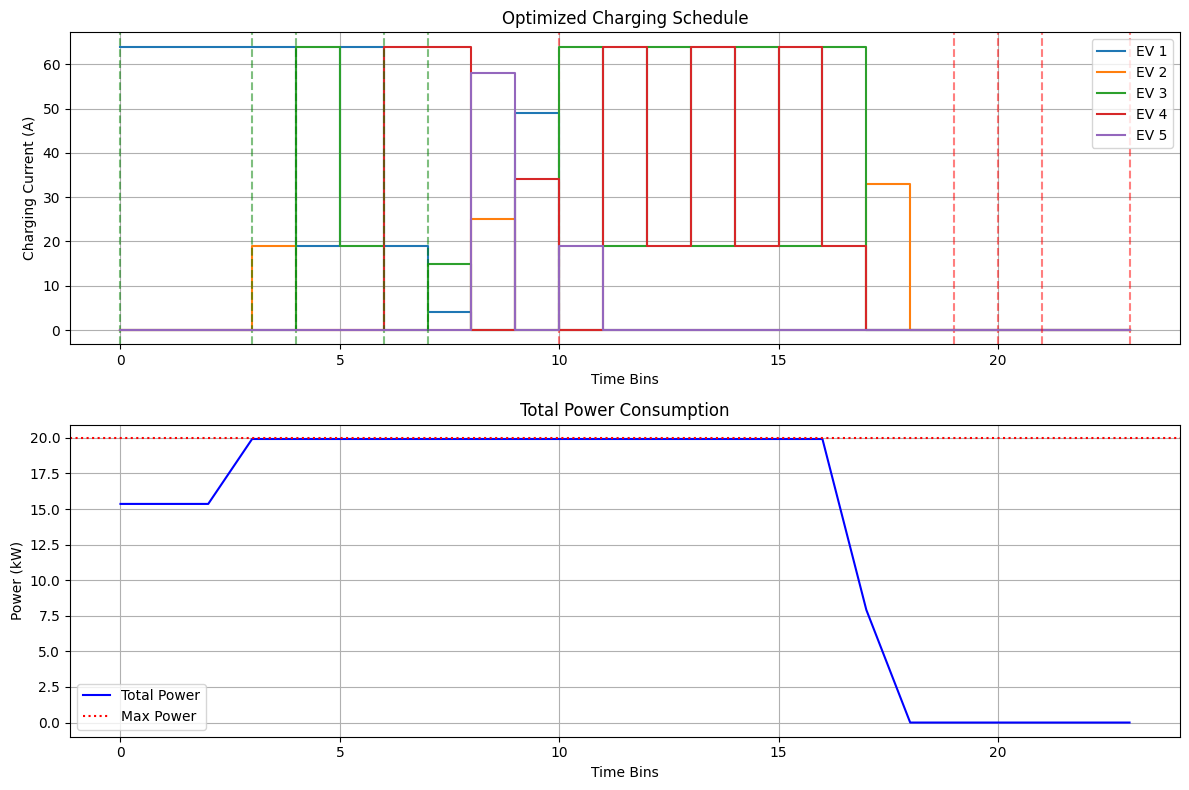

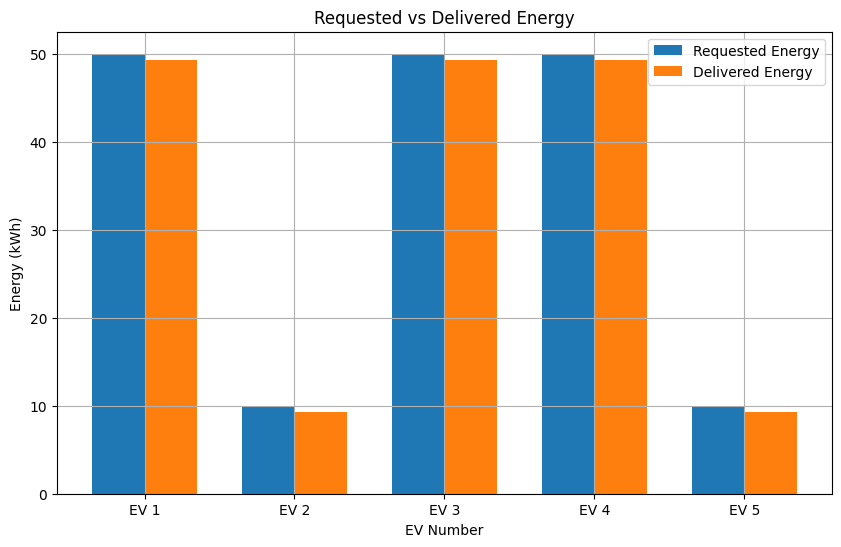

In [17]:
if optimized_schedule is not None:
    print("Optimized Charging Schedule (Amperes):")
    print(optimized_schedule)

    # Calculate delivered energy
    delivered_energy = np.sum(optimized_schedule, axis=1) * V * dt / 1000
    print("\nDelivered Energy (kWh):")
    print(delivered_energy)

    print("\nRequested Energy (kWh):")
    print(e)

    print(f"\nTotal Energy Delivered: {np.sum(delivered_energy):.2f} kWh")
    print(f"Maximum Power: {max_power} kW")

    # Plotting
    plt.figure(figsize=(12, 8))
    
    # Charging schedule plot
    plt.subplot(2, 1, 1)
    for i in range(num_evs):
        plt.step(range(num_bins), optimized_schedule[i], label=f'EV {i+1}', where='post')
        plt.axvline(x=arr_times[i], color='g', linestyle='--', alpha=0.5)
        plt.axvline(x=dep_times[i], color='r', linestyle='--', alpha=0.5)

    plt.xlabel('Time Bins')
    plt.ylabel('Charging Current (A)')
    plt.title('Optimized Charging Schedule')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Total power consumption plot
    plt.subplot(2, 1, 2)
    total_power = np.sum(optimized_schedule, axis=0) * V / 1000
    plt.plot(range(num_bins), total_power, 'b-', label='Total Power')
    plt.axhline(y=max_power, color='r', linestyle=':', label='Max Power')
    plt.xlabel('Time Bins')
    plt.ylabel('Power (kW)')
    plt.title('Total Power Consumption')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Energy delivery plot
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(num_evs)
    plt.bar(index, e, bar_width, label='Requested Energy')
    plt.bar(index + bar_width, delivered_energy, bar_width, label='Delivered Energy')
    plt.xlabel('EV Number')
    plt.ylabel('Energy (kWh)')
    plt.title('Requested vs Delivered Energy')
    plt.xticks(index + bar_width/2, [f'EV {i+1}' for i in range(num_evs)])
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Optimization failed to find a solution.")